### K-Means vs DBSCAN

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ecdf
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [15]:
df = pd.read_csv('med_events_ATC.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values(['PATIENT_ID', 'DATE'])

# Calculate time between prescriptions
df['prev_date'] = df.groupby('PATIENT_ID')['DATE'].shift(1)
df = df.dropna(subset=['prev_date'])
df['event_interval'] = (df['DATE'] - df['prev_date']).dt.days

# Filter out extreme intervals (>5 years)
df = df[df['event_interval'] <= 365*5]

# Create a prescription number
df['prescription_num'] = df.groupby('PATIENT_ID').cumcount() + 1

print(f"Shape of dataset after filtering: {df.shape}")
df.head()


Shape of dataset after filtering: (1548, 10)


,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2,prev_date,event_interval,prescription_num
12,1,2056-10-09,30.000000,100.0,R03AC12,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES,2056-10-09,0,1
4,1,2056-12-10,40.000000,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES",2056-10-09,62,2
5,1,2057-02-12,11.000000,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES",2056-12-10,64,3
6,1,2057-02-23,3.767442,86000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES",2057-02-12,11,4
7,1,2057-02-24,34.186047,86000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES",2057-02-23,1,5


### K-Means

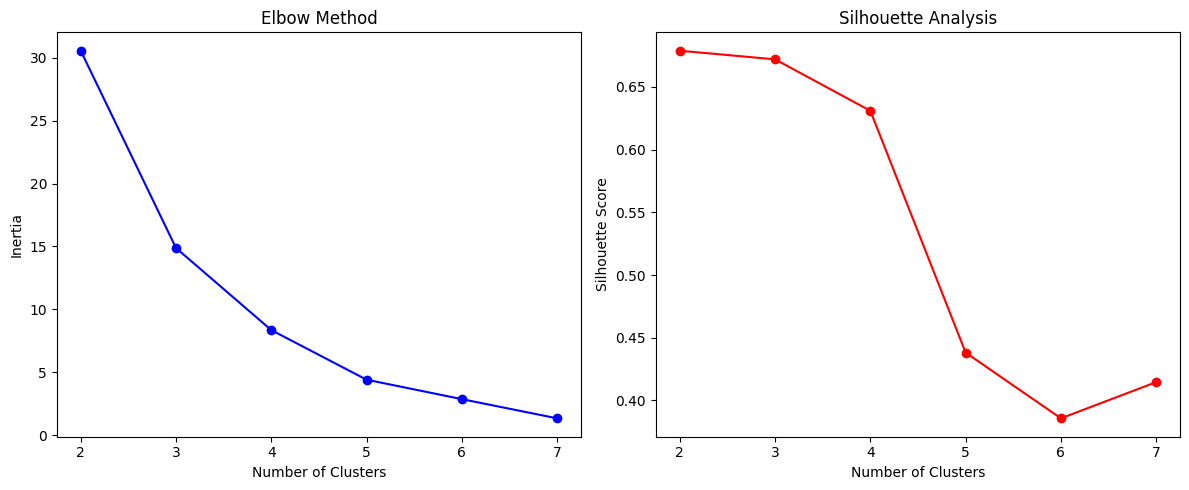

Cluster Characteristics:


cluster mean_interval           std_interval num_refills max_interval
                   mean       std         mean        mean         mean
0       0      5.953292  1.655696    12.320583  125.833333    57.916667
1       1     74.600000       NaN   166.810671    5.000000   373.000000
2       2     50.210101  5.292419    63.565296   11.000000   219.000000

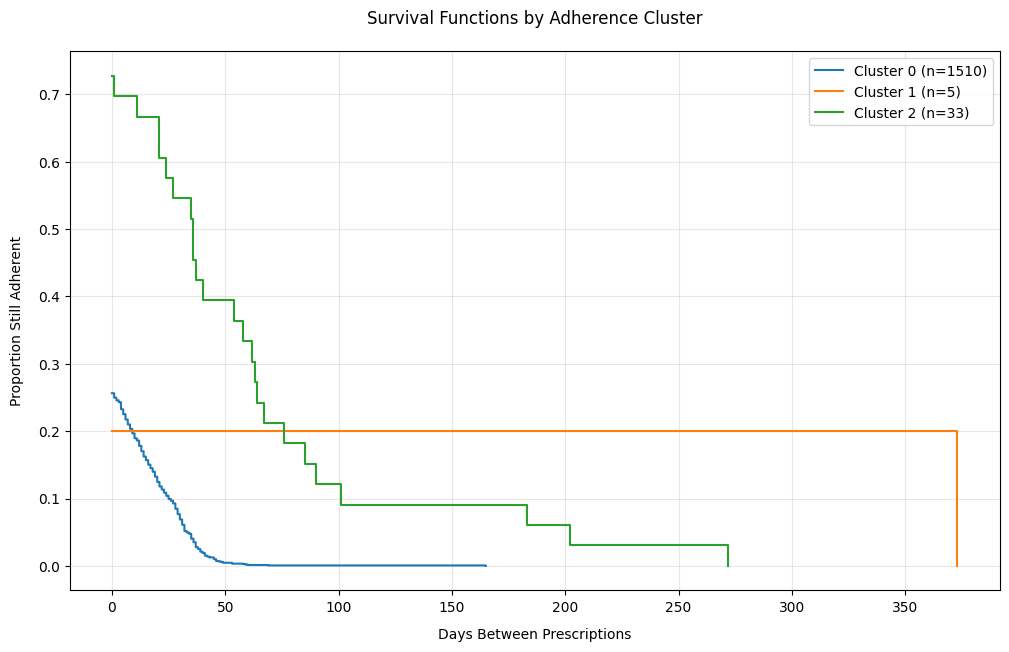


Key Insights:

Cluster 0 (12 patients):
- Average refill interval: 6.0 days
- Average number of refills: 125.8
- Typical behavior: Good adherence

Cluster 1 (1 patients):
- Average refill interval: 74.6 days
- Average number of refills: 5.0
- Typical behavior: Poor adherence

Cluster 2 (3 patients):
- Average refill interval: 50.2 days
- Average number of refills: 11.0
- Typical behavior: Moderate adherence


In [16]:
patient_features = df.groupby('PATIENT_ID').agg(
    mean_interval=('event_interval', 'mean'),
    std_interval=('event_interval', 'std'),
    num_refills=('event_interval', 'count'),
    max_interval=('event_interval', 'max'),
    q25=('event_interval', lambda x: np.quantile(x, 0.25)),
    q75=('event_interval', lambda x: np.quantile(x, 0.75))
).reset_index()

# Handle missing values from std calculation
patient_features['std_interval'] = patient_features['std_interval'].fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(patient_features.drop('PATIENT_ID', axis=1))

# %%
# Determine optimal k using Elbow Method
inertia = []
silhouette = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled_features, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# %%
# Final clustering with k=3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
patient_features['cluster'] = kmeans.fit_predict(scaled_features)

# Add cluster labels to original dataframe
df = df.merge(patient_features[['PATIENT_ID', 'cluster']], on='PATIENT_ID')

# %%
# Cluster analysis
cluster_stats = patient_features.groupby('cluster').agg({
    'mean_interval': ['mean', 'std'],
    'std_interval': 'mean',
    'num_refills': 'mean',
    'max_interval': 'mean'
}).reset_index()

print("Cluster Characteristics:")
display(cluster_stats)

# %%
# Sessa Estimator Implementation
def sessa_estimator(intervals):
    res = ecdf(intervals)
    x = np.sort(intervals)
    y = 1 - res.cdf.evaluate(x)
    return x, y

# Plot survival curves for each cluster
plt.figure(figsize=(12, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for cluster in range(optimal_k):
    cluster_intervals = df[df['cluster'] == cluster]['event_interval']
    x, y = sessa_estimator(cluster_intervals)
    plt.step(x, y, where='post', 
             label=f'Cluster {cluster} (n={len(cluster_intervals)})',
             color=colors[cluster])

plt.title('Survival Functions by Adherence Cluster', pad=20)
plt.xlabel('Days Between Prescriptions', labelpad=10)
plt.ylabel('Proportion Still Adherent', labelpad=10)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# %%
# Generate insights
print("\nKey Insights:")
for cluster in range(optimal_k):
    cluster_data = patient_features[patient_features['cluster'] == cluster]
    n_patients = cluster_data.shape[0]
    avg_refills = cluster_data['num_refills'].mean()
    avg_interval = cluster_data['mean_interval'].mean()
    
    print(f"\nCluster {cluster} ({n_patients} patients):")
    print(f"- Average refill interval: {avg_interval:.1f} days")
    print(f"- Average number of refills: {avg_refills:.1f}")
    print(f"- Typical behavior: {'Good adherence' if avg_interval < 30 else 'Moderate adherence' if avg_interval < 60 else 'Poor adherence'}")


### DBSCAN

In [17]:
patient_features = df.groupby('PATIENT_ID').agg(
    mean_interval=('event_interval', 'mean'),
    std_interval=('event_interval', 'std'),
    num_refills=('event_interval', 'count'),
    max_interval=('event_interval', 'max'),
    q25=('event_interval', lambda x: np.quantile(x, 0.25)),
    q75=('event_interval', lambda x: np.quantile(x, 0.75))
).reset_index()

# Handle missing values from std calculation
patient_features['std_interval'] = patient_features['std_interval'].fillna(0)

# Scale features (excluding PATIENT_ID)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(patient_features.drop('PATIENT_ID', axis=1))

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)
patient_features['cluster'] = dbscan.fit_predict(scaled_features)

# Merge cluster labels into the original dataframe
df = df.merge(patient_features[['PATIENT_ID', 'cluster']], on='PATIENT_ID')

# Cluster analysis
cluster_stats = patient_features.groupby('cluster').agg({
    'mean_interval': ['mean', 'std'],
    'std_interval': 'mean',
    'num_refills': 'mean',
    'max_interval': 'mean'
}).reset_index()

print("Cluster Characteristics (DBSCAN):")
display(cluster_stats)

# Sessa Estimator Implementation
def sessa_estimator(intervals):
    res = ecdf(intervals)
    x = np.sort(intervals)
    y = 1 - res.cdf.evaluate(x)
    return x, y

# Plot survival curves for each cluster produced by DBSCAN
plt.figure(figsize=(12, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'red', 'pink', 'purple']
clusters = sorted(patient_features['cluster'].unique())

for cluster in clusters:
    cluster_intervals = df[df['cluster'] == cluster]['event_interval']
    if len(cluster_intervals) == 0:
        continue
    x, y = sessa_estimator(cluster_intervals)
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"
    plt.step(x, y, where='post', 
             label=f'{label} (n={len(cluster_intervals)})',
             color=colors[clusters.index(cluster) % len(colors)])

plt.title('Survival Functions by Adherence Cluster (DBSCAN)', pad=20)
plt.xlabel('Days Between Prescriptions', labelpad=10)
plt.ylabel('Proportion Still Adherent', labelpad=10)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print("\nKey Insights (DBSCAN Clustering):")
for cluster in clusters:
    cluster_data = patient_features[patient_features['cluster'] == cluster]
    n_patients = cluster_data.shape[0]
    if n_patients == 0:
        continue
    avg_refills = cluster_data['num_refills'].mean()
    avg_interval = cluster_data['mean_interval'].mean()
    
    behavior = 'Good adherence' if avg_interval < 30 else 'Moderate adherence' if avg_interval < 60 else 'Poor adherence'
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"
    
    print(f"\n{label} ({n_patients} patients):")
    print(f"- Average refill interval: {avg_interval:.1f} days")
    print(f"- Average number of refills: {avg_refills:.1f}")
    print(f"- Typical behavior: {behavior}")

# %%
# Temporal pattern analysis by month
df['month'] = df['DATE'].dt.month
monthly_clusters = df.groupby(['month', 'cluster']).size().unstack()

plt.figure(figsize=(12, 6))
monthly_clusters.plot(kind='bar', stacked=True, color=colors)
plt.title('Monthly Prescription Patterns by Cluster (DBSCAN)')
plt.xlabel('Month')
plt.ylabel('Number of Prescriptions')
plt.xticks(rotation=0)
plt.show()

Cluster Characteristics (DBSCAN):


cluster mean_interval            std_interval num_refills max_interval
                   mean        std         mean        mean         mean
0      -1     46.129884  25.366700    74.691626   34.800000        239.0
1       0      5.667786   0.866116    12.699626  110.333333         50.0
2       1      7.943603   0.565410    13.747515   89.500000         53.5
3       2      4.310652   0.419110     9.701623  171.250000         41.5

KeyError: 'cluster'

<Figure size 1200x700 with 0 Axes>

In [ ]:
def boxplot_prescription_intervals_km(df, cluster_label='cluster', max_prescription=10):
    df_sorted = df.sort_values(['PATIENT_ID','DATE']).copy()
    df_sorted['p_number'] = df_sorted.groupby('PATIENT_ID').cumcount() + 1
    
    df_filtered = df_sorted[
        (df_sorted['p_number'] >= 2) &
        (df_sorted['p_number'] <= max_prescription)
    ].copy()
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='p_number', y='event_interval', 
                hue=cluster_label, data=df_filtered, showfliers=True)
    plt.title('K-Means: Days Between Prescriptions by Prescription Number & Cluster')
    
    overall_median = df_filtered['event_interval'].median()
    plt.axhline(overall_median, color='r', linestyle='--', 
                label=f'Median: {overall_median:.1f} days')
    
    plt.xlabel('Prescription Number')
    plt.ylabel('Days Between Prescriptions')
    plt.legend()
    plt.show()